In [61]:
import sys
sys.path.append('../../')

import torch as th
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from lgd.degradations import *
from lgd.optimizers.learnable import LearnedGradientDescentOptimizer
from lgd.modules.srresnet import MSRResNet
DEVICE = 'cuda'

def psnr(x, y):
    se = th.nn.functional.mse_loss(x, y, reduction="none")
    if len(se.shape) == 1:
        mse = se
    else:
        mse = se.mean(dim=list(range(1, len(se.shape))))
    psnr = 10 * th.log10(th.tensor(1 ** 2) / mse)
    return psnr

# Loading data

In [ ]:
noisy_data = sorted(glob('/cache/data/BSD500/test_denoise/noisy25/*.png'))
gt_data = sorted(glob('/cache/data/BSD500/test_denoise/original_png/*.png'))

# Init degradation and LGD solver

In [53]:
path_to_checkpoint = '/cache/storage/lgd_denoise_(stds_5-50)_no-hidden_rnn10_bgl/last/network'
noise_std = 25/255
num_steps = 10

degradation = NoiseDegradation(noise_std, device=DEVICE)
ckpt = th.load(path_to_checkpoint, map_location=DEVICE)
backbone_in_channel = ckpt['backbone.conv_first.weight'].shape[1]
backbone = MSRResNet(num_in_ch=backbone_in_channel, num_out_ch=3, num_feat=64, num_block=4, upscale=1).to(DEVICE)
backbone_hidden_state = None
if np.any(['hidden_state' in key for key in ckpt]):
    backbone_hidden_state = MSRResNet(num_in_ch=backbone_in_channel, num_out_ch=1, num_feat=16, num_block=2, 
                                      upscale=1).to(DEVICE)
solver = LearnedGradientDescentOptimizer(degradation, backbone, num_steps, hidden_state_network=backbone_hidden_state, 
                                         device=DEVICE)
solver.load_state_dict(ckpt)

<All keys matched successfully>

# Test on BSD68-25

In [54]:
psnrs = []
for noisy, gt in tqdm(zip(noisy_data, gt_data)):
    noisy = (th.FloatTensor(cv2.imread(noisy)).div(255).to(device=DEVICE).permute(2, 0, 1).unsqueeze(0).contiguous() - 0.5)*2
    gt = th.FloatTensor(cv2.imread(gt)).div(255).to(device=DEVICE).permute(2, 0, 1).unsqueeze(0).contiguous()
    with th.no_grad():
        result = solver.restore(noisy)
    result = (result + 1)/2
    result = th.clamp(result, 0, 1)
    psnrs.append(psnr(result, gt)[0].cpu().numpy())
print(f'Averaged PSNR obtained: {np.mean(psnrs)}')

HBox(children=(FloatProgress(value=1.0, bar_style='info', max=1.0), HTML(value='')))


Averaged PSNR obtained: 30.499313354492188


# Look at images

## Final prediction

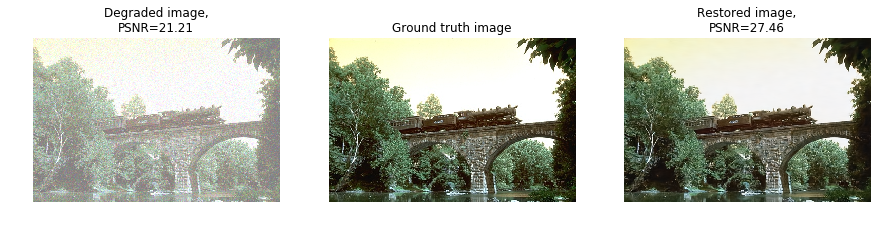

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
noisy = (noisy + 1)/2
ax[0].imshow((noisy[0].permute(1,2,0).cpu() + 1)/2)
ax[0].axis('off')
ax[0].set_title(f'Degraded image,\nPSNR={str(np.round(psnr(noisy, gt).cpu().numpy(), 2)[0])}')
ax[1].imshow(gt[0].permute(1,2,0).cpu())
ax[1].axis('off')
ax[1].set_title('Ground truth image');
ax[2].imshow(result[0].permute(1,2,0).cpu())
ax[2].axis('off')
ax[2].set_title(f'Restored image,\nPSNR={str(np.round(psnr(result, gt).cpu().numpy(), 2)[0])}');

## By stages

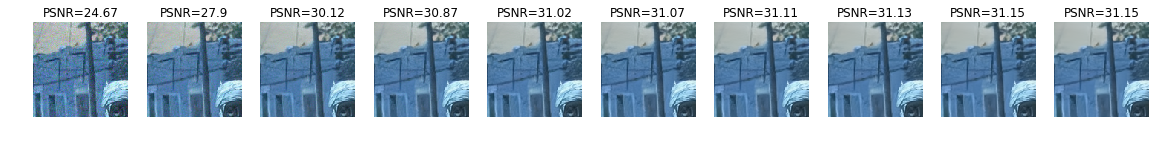

In [63]:
noisy, gt  = random.choice(list(zip(noisy_data, gt_data)))
noisy = (th.FloatTensor(cv2.imread(noisy)).div(255).to(device=DEVICE).permute(2, 0, 1).unsqueeze(0).contiguous() - 0.5)*2
gt = th.FloatTensor(cv2.imread(gt)).div(255).to(device=DEVICE).permute(2, 0, 1).unsqueeze(0).contiguous()
with th.no_grad():
    result = solver.restore(noisy, track_updates_history=True)
result = (th.cat(result, dim=0) + 1)/2
result = th.clamp(result, 0, 1)

fig, ax = plt.subplots(nrows=1, ncols=num_steps, figsize=(2*num_steps, 2))
for i in range(num_steps):
    p = np.round(psnr(result[i], gt[0])[0].cpu().numpy(), 2)
    ax[i].imshow(result[i, :, :128, :128].permute(1,2,0).cpu())
    ax[i].axis('off')
    ax[i].set_title(f'PSNR={str(p)}')